In [1]:
import json
import os
import subprocess
import glob

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json
import copy

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy
from scipy.optimize import curve_fit

import ast

from scipy.special import erf
import scipy.optimize as opt
from matplotlib.ticker import FixedLocator
from scipy.stats import norm

import uproot 


In [59]:
num_part = int(1e6)

In [57]:
def plot_angular_scan(data_dict, cry_name = 'CRY', normalize = False):
    fig, ax = plt.subplots(figsize=(10, 5))
    data_dict = data_dict.set_index('index').T.to_dict() if isinstance(data_dict, pd.DataFrame) else data_dict
    n_cry_abs = []
    angles = []
    norm_abs = []
    for key in data_dict.keys():
        n_cry_abs.append(data_dict[key][cry_name+'_abs']/num_part)
        angles.append(data_dict[key]['align_angle'])
    
    #ax.axvline(miscut, color='k', linestyle='--', label='Nominal')
    ax.plot(angles, n_cry_abs, marker='o')
    ax.set_xlabel('Angle [rad]', fontsize=12)
    ax.set_ylabel('Absorbed particles', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax2 = ax.twiny()
    ax2.plot(data_dict.keys(), n_cry_abs, alpha=0.0, color='k')
    #ax.set_xticks(range(len(data_dict)))  # Positions
    ax2.set_xticklabels(data_dict.keys(), rotation=90)
    return fig, ax, ax2

In [37]:
p0c = 1e12
miscut = -14.324e-3

In [38]:
coll = xc.EverestCrystal(length=0.004, material=xc.materials.SiliconCrystal, bending_radius = 80.00, angle=0,
                            width=0.002, height=50.0e-3, side='+', lattice='strip', jaw=0, miscut = miscut)

In [39]:
coll.tilt = -miscut 

In [40]:
pot_crit = 21.34
eta = 0.9
dp = 1.92e-10 
bending_radius = 80.0
Rcrit = p0c/(2*np.sqrt(eta)*pot_crit) * (dp/2)
xp_crit = np.sqrt(2*eta*pot_crit/p0c)*(1 - Rcrit/bending_radius)
xp_crit

6.0140584916592415e-06

In [41]:
lower_bound = -6.6e-5 
upper_bound = 3e-5 
step = 1e-6

In [42]:
def simulate_ang_scan(lower_bound = -6.6e-5 , upper_bound = 3e-5 , step = 2e-6):
    rng =  np.arange(lower_bound, upper_bound, step)
    num_part = int(1e6)
    dct_loss = {}
    seed = 1
    np.random.seed(seed=seed)

    for ang in rng:

        coll.tilt = -miscut
        coll.tilt = coll.tilt + ang

        x_init   = np.random.normal(loc=1.5e-3, scale=75.e-6, size=num_part)
        #px_init  = np.random.uniform(low=98.e-6, high=102.e-6, size=num_part)
        px_init  = np.random.uniform(low=-1.e-6, high=1.e-6, size=num_part)
        y_init   = np.random.normal(loc=0., scale=1e-3, size=num_part)
        py_init  = np.random.normal(loc=0., scale=5.e-6, size=num_part)

        part = xp.Particles(x=x_init, px=px_init, y=y_init, py=py_init, delta=0, p0c=p0c)

        random_array = np.random.randint(0, 4291630464,  size = num_part*4)
        part._rng_s1 = random_array[0:num_part]
        part._rng_s2 = random_array[num_part:num_part*2]
        part._rng_s3 = random_array[num_part*2:num_part*3]
        part._rng_s4 = random_array[num_part*3:num_part*4]

        coll.track(part)
        
        p_abs = len(part.state[part.state<0])
        print(coll.tilt, p_abs)
        key = f"{ang*1e6:.0f}"
        dct_loss[key] = {}
        dct_loss[key]['angle'] = coll.tilt  - miscut
        dct_loss[key]['align_angle'] = coll.tilt  
        dct_loss[key]['CRY_abs'] = p_abs
    return dct_loss


In [43]:
lower_bound = -6.6e-5 
upper_bound = 3e-5 
step = 1e-6

dct_loss = simulate_ang_scan(lower_bound = -6.6e-5 , upper_bound = 3e-5 , step = 1e-6)


0.014258 8594
0.014259 8548
0.01426 8502
0.014261 8364
0.014262 8500
0.014263 8495
0.014264 8533
0.014265 8502
0.014266 8433
0.014267 8672
0.014268 8636
0.014269 8346
0.01427 8486
0.014271 8398
0.014272 8502
0.014273 8617
0.014274 7798
0.014275 6737
0.014276 6437
0.014277 6613
0.014278 6642
0.014279 6442
0.01428 6662
0.014281 6427
0.014282 6467
0.014283 6504
0.014284 6705
0.014285 6416
0.014286 6446
0.014287 6628
0.014288 6505
0.014289 6296
0.01429 6572
0.014291 6594
0.014292 6468
0.014293 6422
0.014294 6495
0.014295 6557
0.014296 6397
0.014297 6773
0.014298 6575
0.014299 6470
0.0143 6420
0.014301 6462
0.014302 6305
0.014303 6452
0.014304 6645
0.014305 6589
0.014306 6373
0.014307 6499
0.014308 6474
0.014309 6545
0.01431 6444
0.014311 6466
0.014312 7232
0.014313 8259
0.014314 8481
0.014315 8489
0.014316 8462
0.014317 8546
0.014318 7579
0.014319 5463
0.01432 3312
0.014321 2325
0.014322 1644
0.014323 1171
0.014324 1018
0.014325 1096
0.014326 1367
0.014327 1898
0.014328 2711
0.014329 4059


/tmp/cmaccani/ipykernel_79703/1896421791.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(data_dict.keys(), rotation=90)


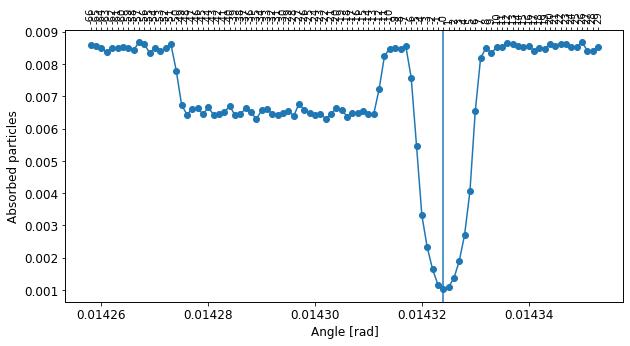

In [60]:
ax = plot_angular_scan(dct_loss)
ax[1].axvline(-miscut)

In [9]:
1.1*19

20.900000000000002

In [13]:
dct_loss_notrans = simulate_ang_scan(lower_bound = -6.9e-5 , upper_bound = 3.3e-5 , step = 1e-6)

0.014255 8596
0.014256 8547
0.014257 8499
0.014258 8365
0.014259 8501
0.01426 8538
0.014261 8498
0.014262 8543
0.014263 8412
0.014264 8645
0.014265 8647
0.014266 8426
0.014267 8498
0.014268 8489
0.014269 8531
0.01427 8602
0.014271 8509
0.014272 8531
0.014273 8460
0.014274 8659
0.014275 8654
0.014276 8504
0.014277 8666
0.014278 8363
0.014279 8467
0.01428 8573
0.014281 8731
0.014282 8538
0.014283 8456
0.014284 8604
0.014285 8598
0.014286 8386
0.014287 8693
0.014288 8575
0.014289 8450
0.01429 8397
0.014291 8493
0.014292 8689
0.014293 8367
0.014294 8769
0.014295 8527
0.014296 8569
0.014297 8524
0.014298 8496
0.014299 8332
0.0143 8498
0.014301 8640
0.014302 8609
0.014303 8410
0.014304 8531
0.014305 8601
0.014306 8624
0.014307 8425
0.014308 8510
0.014309 8494
0.01431 8513
0.014311 8457
0.014312 8445
0.014313 8493
0.014314 8654
0.014315 8559
0.014316 8553
0.014317 8527
0.014318 7562
0.014319 5446
0.01432 3429
0.014321 2409
0.014322 1764
0.014323 1375
0.014324 1150
0.014325 1220
0.014326 1472


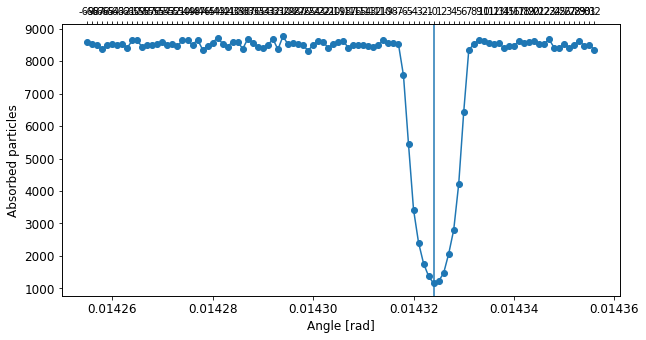

In [14]:
ax = plot_angular_scan(dct_loss_notrans)
ax[1].axvline(-miscut)

In [25]:
num_part = int(1e6)
x_init   = np.random.normal(loc=1e-3, scale=75.e-6, size=num_part)
px_init  = np.random.uniform(low=-1.e-6, high=1.e-6, size=num_part)
y_init   = np.random.normal(loc=0., scale=1e-3, size=num_part)
py_init  = np.random.normal(loc=0., scale=5.e-6, size=num_part)
part = xp.Particles(x=x_init, px=px_init, y=y_init, py=py_init, delta=0, p0c=p0c)

In [26]:
coll.tilt = -miscut - 10e-6


In [27]:
line = xt.Line([coll])
impacts = xc.InteractionRecord.start(line= line, capacity=int(2e7))

In [28]:
part_init = part.copy()

In [29]:
%time coll.track(part)
part_after = part.copy()

CPU times: user 663 ms, sys: 172 ms, total: 835 ms
Wall time: 843 ms


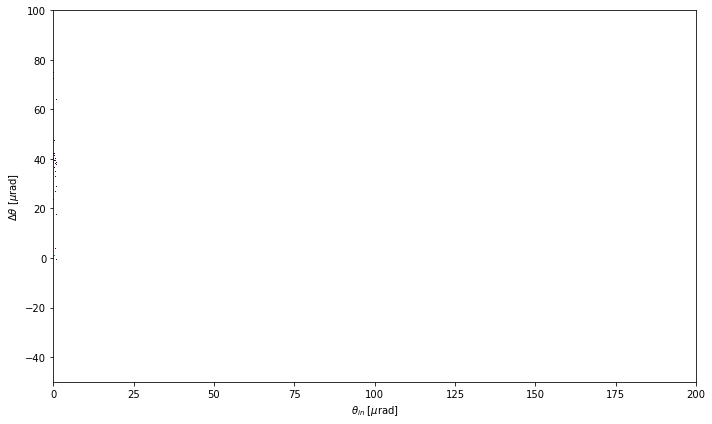

In [32]:
mask = (part.state > 0 ) & ( part.px - part_init.px < 100.e-6) & ( part.px - part_init.px > -50.e-6) & (part.px > - 0) & (part.px<200e-6) #& mask2
# mask = (part.state > 0 ) & mask2

# plt.figure(figsize=(5,10/3))
plt.figure(figsize=(10,6))
# _ = plt.hist2d(part_init.px[mask], (part.px[mask] - part_init.px[mask])/np.sqrt((150.e-6-part_init.px[mask])*1.75e-3/130.e-6), 200, norm=mpl.colors.LogNorm())

# smear_x = np.random.normal(loc=0., scale=5., size=len(part_init.px[mask]))
# smear_y = np.random.normal(loc=0., scale=2.8, size=len(part_init.px[mask]))
smear_x = 0
smear_y = 0
_ = plt.hist2d(part_init.px[mask]*1.e6+smear_x, part.px[mask]*1.e6 - part_init.px[mask]*1.e6 + smear_y, 500, norm=matplotlib.colors.LogNorm())
#_ = plt.hist2d(part_init.px*1.e6+smear_x, part.px*1.e6 - part_init.px*1.e6 + smear_y, 500, norm=matplotlib.colors.LogNorm())
plt.xlim(0, 200)
plt.ylim(-50, 100)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()
# plt.savefig('cry_sixtrack.pdf', dpi=300)

In [171]:
coll.critical_angle

In [87]:
df_imp = impacts.to_pandas()

In [37]:
len(part_after.state[part_after.state<0])

8385

In [38]:
CRY_imp = impacts.interactions_per_collimator().reset_index()
n_CRY_abs = CRY_imp['int'].apply(lambda x: 'A'  in x).sum()

In [39]:
lower_bound = -6.6e-5 
upper_bound = 3e-5
step = 1e-6
rng =  np.arange(lower_bound, upper_bound, step)
num_part = int(1e6)
dct_loss = {}
seed = 1
np.random.seed(seed=seed)


for ang in rng:

    coll.tilt = miscut
    coll.tilt = coll.tilt + ang

    x_init   = np.random.normal(loc=1.5e-3, scale=75.e-6, size=num_part)
    #px_init  = np.random.uniform(low=98.e-6, high=102.e-6, size=num_part)
    px_init  = np.random.uniform(low=0.e-6, high=4.e-6, size=num_part)
    y_init   = np.random.normal(loc=0., scale=1e-3, size=num_part)
    py_init  = np.random.normal(loc=0., scale=5.e-6, size=num_part)

    part = xp.Particles(x=x_init, px=px_init, y=y_init, py=py_init, delta=0, p0c=p0c)

    random_array = np.random.randint(0, 4291630464,  size = num_part*4)
    part._rng_s1 = random_array[0:num_part]
    part._rng_s2 = random_array[num_part:num_part*2]
    part._rng_s3 = random_array[num_part*2:num_part*3]
    part._rng_s4 = random_array[num_part*3:num_part*4]

    coll.track(part)
    
    p_abs = len(part.state[part.state<0])
    print(coll.tilt, p_abs)
    key = f"{ang*1e6:.0f}"
    dct_loss[key] = {}
    dct_loss[key]['angle'] = coll.tilt  - miscut
    dct_loss[key]['align_angle'] = coll.tilt  
    dct_loss[key]['CRY_abs'] = p_abs

8385

In [40]:
CRY_imp

,pid,turn,int
0,0,0,[MCS]
1,1,0,[MCS]
2,2,0,[MCS]
3,3,0,[MCS]
4,4,0,[MCS]
...,...,...,...
999995,999995,0,[MCS]
999996,999996,0,[MCS]
999997,999997,0,"[MCS, VR, MCS]"
999998,999998,0,[MCS]


# TCCS 

In [3]:
p0c = 0.45e12

In [ ]:
tccs.5r3.b2:        { <<: *TCCS3,  gap: 5.0, length: 0.004,  bending_radius: 80.00,  width: 2.0e-3,  height: 35.0e-3, <<: *ALL,  gap: null,  stage: special,    material: Si,   side: left, angle: 90, crystal: strip, active: true} 

In [7]:
coll = xc.EverestCrystal(length=0.004, material=xc.materials.SiliconCrystal, bending_radius = 80.00, angle=90,
                            width=0.002, height=35.0e-3, side='+', lattice='strip', jaw=0)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [12]:
def simulate_ang_scan_TCCS(lower_bound = -6.6e-5 , upper_bound = 3e-5 , step = 2e-6):
    rng =  np.arange(lower_bound, upper_bound, step)
    num_part = int(1e6)
    dct_loss = {}
    seed = 1
    np.random.seed(seed=seed)

    for ang in rng:

        coll.tilt = 0
        coll.tilt = coll.tilt + ang

        y_init   = np.random.normal(loc=1.5e-3, scale=75.e-6, size=num_part)
        #px_init  = np.random.uniform(low=98.e-6, high=102.e-6, size=num_part)
        py_init  = np.random.uniform(low=-1.e-6, high=1.e-6, size=num_part)
        x_init   = np.random.normal(loc=0., scale=1e-3, size=num_part)
        px_init  = np.random.normal(loc=0., scale=5.e-6, size=num_part)

        part = xp.Particles(x=x_init, px=px_init, y=y_init, py=py_init, delta=0, p0c=p0c)

        random_array = np.random.randint(0, 4291630464,  size = num_part*4)
        part._rng_s1 = random_array[0:num_part]
        part._rng_s2 = random_array[num_part:num_part*2]
        part._rng_s3 = random_array[num_part*2:num_part*3]
        part._rng_s4 = random_array[num_part*3:num_part*4]

        coll.track(part)
        
        p_abs = len(part.state[part.state<0])
        print(coll.tilt, p_abs)
        key = f"{ang*1e6:.0f}"
        dct_loss[key] = {}
        dct_loss[key]['angle'] = coll.tilt 
        #dct_loss[key]['align_angle'] = coll.tilt  
        dct_loss[key]['CRY_abs'] = p_abs
    return dct_loss

In [18]:
dct_loss_notrans_TCCS = simulate_ang_scan_TCCS(lower_bound = -6.9e-5 , upper_bound = 6.6e-5 , step = 1e-6)

-6.9e-05 8595
-6.8e-05 8550
-6.7e-05 8501
-6.6e-05 8364
-6.5e-05 8499
-6.4e-05 8537
-6.3e-05 8496
-6.2e-05 8542
-6.1e-05 8409
-6e-05 8642
-5.9e-05 8645
-5.8e-05 8425
-5.7e-05 8498
-5.6e-05 8487
-5.5e-05 8525
-5.4e-05 8602
-5.3e-05 8510
-5.2e-05 8531
-5.1e-05 8461
-5e-05 8678
-4.9e-05 8660
-4.8e-05 8511
-4.7e-05 8676
-4.6e-05 8356
-4.5e-05 8479
-4.4e-05 8577
-4.3e-05 8736
-4.2e-05 8545
-4.1e-05 8449
-4e-05 8606
-3.9e-05 8602
-3.8e-05 8403
-3.7e-05 8696
-3.6e-05 8590
-3.5e-05 8472
-3.4e-05 8425
-3.3e-05 8489
-3.2e-05 8726
-3.1e-05 8388
-3e-05 8796
-2.9e-05 8523
-2.8e-05 8585
-2.7e-05 8509
-2.6e-05 8518
-2.5e-05 8341
-2.4e-05 8520
-2.3e-05 8662
-2.2e-05 8613
-2.1e-05 8425
-2e-05 8538
-1.9e-05 8617
-1.8e-05 8687
-1.7e-05 8466
-1.6e-05 8550
-1.5e-05 8527
-1.4e-05 8547
-1.3e-05 8533
-1.2e-05 8488
-1.1e-05 8530
-1e-05 8725
-9e-06 8405
-8e-06 7657
-7e-06 6435
-6e-06 5267
-5e-06 4104
-4e-06 3232
-3e-06 2539
-2e-06 2096
-1e-06 1846
-0.0 1715
1e-06 1784
2e-06 2022
3e-06 2510
4e-06 3290
5e-06 4181

In [15]:
def plot_angular_scan(data_dict, cry_name = 'CRY', normalize = False):
    fig, ax = plt.subplots(figsize=(10, 5))
    data_dict = data_dict.set_index('index').T.to_dict() if isinstance(data_dict, pd.DataFrame) else data_dict
    n_cry_abs = []
    angles = []
    norm_abs = []
    for key in data_dict.keys():
        n_cry_abs.append(data_dict[key][cry_name+'_abs'])
        angles.append(data_dict[key]['angle'])
    
    #ax.axvline(miscut, color='k', linestyle='--', label='Nominal')
    ax.plot(angles, n_cry_abs, marker='o')
    ax.set_xlabel('Angle [rad]', fontsize=12)
    ax.set_ylabel('Absorbed particles', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax2 = ax.twiny()
    ax2.plot(data_dict.keys(), n_cry_abs, alpha=0.0, color='k')
    return fig, ax, ax2

(<Figure size 720x360 with 2 Axes>,
 <Axes: xlabel='Angle [rad]', ylabel='Absorbed particles'>,
 <Axes: >)

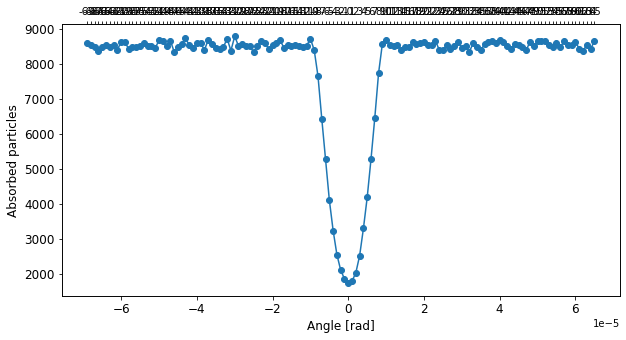

In [19]:
plot_angular_scan(dct_loss_notrans_TCCS)

# test pencil

In [3]:
line_file_b2 = "../MadX/2025/injection/track_injection_b2.json"
#line_file_b2 =

In [4]:
line = xt.Line.from_json(line_file_b2)

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


In [5]:
end_s = line.get_length()

TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
PIXEL_name = 'pixel.detector'
TFT_name = 'tft.detector'
TCP_name = 'tcp.d6r7.b2'
TCLA_name = 'tcla.a5l3.b2'


TCCS_loc_abs  = 6773.9428  #6773.7 #6775
TCCP_loc_abs  = 6653.2543  #6653.3 #6655
PIX1_loc_abs = 6652.7039
PIX2_loc_abs = 6652.6929
PIX3_loc_abs = 6652.6819
TFT_loc_abs = 6652.114

TCCS_loc = end_s - TCCS_loc_abs
TCCP_loc = end_s - TCCP_loc_abs
TARGET_loc = end_s - (TCCP_loc_abs + 0.07/2 +10000/2)
PIX1_loc = end_s - PIX1_loc_abs
PIX2_loc = end_s - PIX2_loc_abs
PIX3_loc = end_s - PIX3_loc_abs
TFT_loc = end_s - TFT_loc_abs
TCP_loc = line.get_s_position()[line.element_names.index(TCP_name)]
TCLA_loc = line.get_s_position()[line.element_names.index(TCLA_name)]


line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name=TCCS_name)
line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCS_name+'_aper')
line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name=TCCP_name+'_aper')
line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= TARGET_name + '_aper')
line.insert_element(at_s=PIX1_loc, element=xt.Marker(), name=PIXEL_name+'_1')
line.insert_element(at_s=PIX1_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_1' + '_aper')
line.insert_element(at_s=PIX2_loc, element=xt.Marker(), name=PIXEL_name+'_2')
line.insert_element(at_s=PIX2_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_2' + '_aper')
line.insert_element(at_s=PIX3_loc, element=xt.Marker(), name=PIXEL_name+'_3')
line.insert_element(at_s=PIX3_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name= PIXEL_name+'_3' + '_aper')
line.insert_element(at_s=TFT_loc, element=xt.Marker(), name=TFT_name)

Slicing line:   0%|          | 0/102068 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102071 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102074 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102077 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102080 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102083 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/102086 [00:00<?, ?it/s]

<Line  at 140193972880960>

In [6]:
colldb = xc.CollimatorDatabase.from_yaml("../input_files/colldbs/TWOCRYST_colldb_450GeV.yaml", beam=2, ignore_crystals=False)
colldb.install_everest_collimators(line = line, verbose=True)

Installing tcpcv.a6r7.b2        as EverestCrystal
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Installing tcsg.b5r7.b2         as EverestCollimator
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Installing tcspm.6l7.b2         as EverestCollimator
Installing tcl.4l5.b2           as EverestCollimator
Installing tcp.6r3.b2           as EverestCollimator
Installing tcsg.a5l3.b2         as EverestCollimator
Installing tcsg.4l3.b2          as EverestCollimator
Installing tcsp.a4l6.b2         as EverestCollimator
Installing target.4l3.b2        as EverestCollimator
Installing tcld.a11l2.b2        as EverestCollimator
Installing pixel.detector_3     as EverestCollimator
Installing tctph.4r5.b2         as EverestCollimator
Installing tcp.c6r7.b2          as EverestCollimator
Installing tcla.c6l7.b2         as EverestCollimator
Installing tcl.5l5.b2           as EverestCollimator
Installing tcsg.b4r7.b2         as EverestCollimator
Installing tcsg.b5l3.

Slicing line:   0%|          | 0/102088 [00:00<?, ?it/s]

In [7]:
tw = line.twiss()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [8]:
line.collimators.assign_optics()

In [9]:
line[TCCP_name].align_to_beam_divergence()
line[TCCS_name].align_to_beam_divergence()

In [12]:
tw['alfy', TCCS_name]

1.645488511272413

In [13]:
tw['alfx', 'tcp.c6r7.b2']

1.8531907096868934

In [13]:
part = line['tcp.c6r7.b2'].generate_pencil(num_particles = 10)


---- 
 0.0 -7.576502365299776e-05 True 
----

Collimator tcp.c6r7.b2 is converging.


In [26]:
tw['alfy', TCCP_name]

-3.0597805375693876

In [24]:
line[TCCP_name].divergence

1.5518372717691833e-05

In [25]:
coll = line[TCCP_name]
plane = 'y'
tilt = coll.tilt[0] if isinstance(coll.tilt, list) else coll.tilt
beta0 = line.particle_ref.beta0[0]
gamma0 = line.particle_ref.gamma0[0]
gemitts = {'x': coll.nemitt_x / beta0 / gamma0,
            'y': coll.nemitt_y / beta0 / gamma0}
betatron_angle = -coll.gap * tw[f'alf{plane}', TCCP_name] * np.sqrt(gemitts[plane] / tw[f'bet{plane}', TCCP_name])
tolerance_tilt = 1e-7 # 0.1 urad tolerance on jaw tilt

In [10]:
tolerance_tilt = 1e-7 


In [27]:
line[TCCP_name].divergence

1.5518372717691833e-05

In [28]:
line[TCCP_name].tilt + tolerance_tilt > betatron_angle

True

In [19]:
print(xc.__version__)

0.5.12


In [29]:
betatron_angle2 = coll.gap * coll.divergence

In [30]:
betatron_angle2

0.00015518372717691833

In [31]:
betatron_angle2 = line[TCCS_name].gap * line[TCCS_name].divergence
line[TCCS_name].align_to_beam_divergence()

In [32]:
line[TCCS_name].tilt + tolerance_tilt - betatron_angle2

1.0002510478151696e-07

In [33]:
line[TCCS_name].tilt 

-4.56412e-05

In [34]:
betatron_angle2

-4.5641225104781514e-05

In [11]:
part = line[TCCS_name].generate_pencil(num_particles = 10)


---- 
 -4.56412e-05 -4.5641198999999997e-05 -4.5641225104781514e-05 True 
----

Collimator tccs.5r3.b2 is converging.


In [12]:
part = line[TCCP_name].generate_pencil(num_particles = 10)


---- 
 0.0001551837 0.000155183701 0.00015518372717691833 False 
----

Collimator tccp.4l3.b2 is diverging.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [16]:

0.0001551837> 0.00015518372717691833 


False

In [15]:
0.0001551837 + tolerance_tilt > 0.00015518372717691833 

True

In [17]:
0.0001551837 + tolerance_tilt 

0.0001552837

In [18]:
tolerance_tilt

1e-07

In [62]:
name = TCCP_name
beam_sizes = tw.get_beam_covariance(nemitt_x=line[TCCP_name].nemitt_x, nemitt_y=line[TCCP_name].nemitt_y)
plane = 'y'
transv_plane = 'x'
sigma = beam_sizes.rows[name:f'{name}>>1'][f'sigma_{plane}'][0]
sigma_transv = beam_sizes.rows[name:f'{name}>>1'][f'sigma_{transv_plane}'][0]
tw_at_s = tw.rows[name]
at_element = name
sigma, sigma_transv, tw_at_s, at_element

(0.0014388958867790674,
 0.0007433345277324364,
 TwissTable: 1 row, 62 cols
 name                    s             x            px             y            py          zeta ...
 tccp.4l3.b2       20005.6   9.26143e-07   1.61713e-08  -6.49899e-07  -4.85394e-09  -2.05468e-06,
 'tccp.4l3.b2')

In [64]:
# pencil at back of jaw
sigma = beam_sizes.rows[name:f'{name}>>1'][f'sigma_{plane}'][1]
sigma_transv = beam_sizes.rows[name:f'{name}>>1'][f'sigma_{transv_plane}'][1]
tw_at_s = tw.rows[f'{name}>>1']
at_element = line.element_names[line.element_names.index(name)+1]
sigma, sigma_transv, tw_at_s, at_element

(0.0014399822146527103,
 0.0007421654440245123,
 TwissTable: 1 row, 62 cols
 name                                    s             x            px             y            py ...
 tccp.4l3.b2_aper_downstream       20005.7   9.27275e-07   1.61713e-08  -6.50239e-07  -4.85394e-09,
 'tccp.4l3.b2_aper_downstream')

In [19]:
line_name = "../MD_Energy_Ramp/track_injection_b2.json"
line = xt.Line.from_json(line_name)

Loading line from dict:   0%|          | 0/102068 [00:00<?, ?it/s]

Done loading line from dict.           


In [20]:
collimators = "collimators_MD.yaml" 
sim_dict = "MD_dict.json"

In [21]:
CRY_name ='tcpch.a5r7.b2'
colldb = xc.CollimatorDatabase.from_yaml(collimators, beam=2, ignore_crystals=False)

In [22]:
tw = line.twiss()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [23]:
tw['alfx', CRY_name]

-3.542768392822383

In [24]:
line.discard_tracker()
colldb.install_everest_collimators(line = line,verbose=True)

Installing tcpcv.a6r7.b2        as EverestCrystal
Installing tcsg.b5r7.b2         as EverestCollimator
Installing tcspm.6l7.b2         as EverestCollimator
Installing tcl.4l5.b2           as EverestCollimator
Installing tcp.6r3.b2           as EverestCollimator
Installing tcsg.a5l3.b2         as EverestCollimator
Installing tcsg.4l3.b2          as EverestCollimator
Installing tcsp.a4l6.b2         as EverestCollimator
Installing tcld.a11l2.b2        as EverestCollimator
Installing tctph.4r5.b2         as EverestCollimator
Installing tcp.c6r7.b2          as EverestCollimator
Installing tcla.c6l7.b2         as EverestCollimator
Installing tcl.5l5.b2           as EverestCollimator
Installing tcsg.b4r7.b2         as EverestCollimator
Installing tcsg.b5l3.b2         as EverestCollimator
Installing tcsg.5r3.b2          as EverestCollimator
Installing tcla.6l3.b2          as EverestCollimator
Installing tcsg.e5l7.b2         as EverestCollimator
Installing tcla.7l3.b2          as EverestCollima

Slicing line:   0%|          | 0/102068 [00:00<?, ?it/s]

In [25]:
line.build_tracker()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [26]:
line.collimators.assign_optics()

In [31]:
line[CRY_name].gap = 6.0

In [32]:
line[CRY_name].align_to_beam_divergence()

In [34]:
part = line[CRY_name].generate_pencil(num_particles = 100)


---- 
 0.0001277192 0.000127719201 0.00012771921874891684 False 
----

Collimator tcpch.a5r7.b2 is diverging.
